## 1 - Import Necessary Modules

In [2]:
import cartopy 
import cartopy.io.shapereader as shpreader 
import cartopy.io.shapereader as Reader 
import geopandas as gpd
import matplotlib.pyplot as plt 
import numpy as np 
import proplot as plot
import proplot
import salem
import xarray as xr 

from cartopy.feature import ShapelyFeature 
from glob import glob
from mpl_toolkits.axes_grid1.inset_locator import inset_axes 
from netCDF4 import Dataset 
from shapely.geometry import mapping
from visjobs.visualize import easy_plot
from wrf import getvar, interpline, CoordPair, xy_to_ll, ll_to_xy 

# warnings
import warnings
warnings.filterwarnings('ignore')

## 2. Open Terra-Aqua Data

In [3]:
ds = pd.read_excel(r'\datasets\ankara_0918T.xlsx', na_values=-999.0)
MODIS_terra_data = xr.open_dataset(r'\datasets\gathered\Ankara_MODIS_Terra_1018.nc')
MODIS_aqua_data = xr.open_dataset(r'\datasets\gathered_aqua\Ankara_MODIS_Aqua_1018.nc')

## 3. AWS Monthly UHI between 2009-2018

In [4]:
stations_selected = {'17127' : [837, 40.0788, 32.5657, 'Akıncı Airport'],
                     '17128' : [958, 40.124, 32.9992, 'Esenboğa Airport'],
                     '17129' : [807, 39.9558, 32.6854, 'Etimesgut Airport'],
                     '17130': [890, 39.9727, 32.8637, 'Ankara Bölge'],
                     '17131' : [819, 39.9343, 32.7387, 'Güvercinlik Airport'],
                     '17134': [1098, 39.8032, 32.8434, 'Ufuk Danışment'],
                     '17137': [1797, 39.7985, 32.9716, 'Elmadağ Radar'],
                     '17651' : [940, 39.1525, 32.1283, 'Polatlı Tigem'],
                     '17664' : [1030, 40.4729, 32.6441, 'Kızılcahamam'],
                     '17679' : [648, 40.1733, 31.332, 'Nallıhan'],
                     '17680' : [680, 40.1608, 31.9172, 'Beypazarı'],
                     '17715' : [1113, 39.92, 33.2125, 'Elmadağ Barutsan Fabrikası'],
                     '17728' : [886, 39.5834, 32.1624, 'Polatlı'],
                     '17729' : [1248, 39.5546, 33.1089, 'Bala'],
                     '17731' : [911, 38.9539, 33.4218, 'Şereflikoçhisar'],
                     '17733' : [1065, 39.613, 32.672, 'Haymana Tarım']}

urban1 = stations_selected['17130'] #ankara bölge
urban2 = stations_selected['17131'] #güvercinlik airport
rural1 = stations_selected['17128'] #esenboğa airport
rural2 = stations_selected['17134'] #ufuk danışment - gölbaşı

In [5]:
#cancel out altitude differences using a universal lapse rate
dst = ds.copy(deep=True)
for i in stations_selected:
    factor = (stations_selected[i][0] * 0.65) / 100 # cancel out altitude differences
    dst[int(i)] = dst[int(i)] + factor

In [6]:
date_used = pd.date_range('2009-01-01 00', '2018-12-31 23', freq='1H')
dst.index = date_used

In [7]:
dst.rename(columns={17130: 'urban1', 17131:'urban2', 17128: 'rural1', 17134:'rural2'}, inplace=True)

In [8]:
# resample to daily
dataset = dst[['urban1', 'urban2', 'rural1', 'rural2']].resample('1D').max()

In [9]:
# create a dataframe using UHI values
dataset_UHI = pd.DataFrame()
dataset_UHI['urban1-rural1'] = (dataset['urban1'] - dataset['rural1']).values
dataset_UHI['urban1-rural2'] = (dataset['urban1'] - dataset['rural2']).values
dataset_UHI['urban2-rural1'] = (dataset['urban2'] - dataset['rural1']).values
dataset_UHI['urban2-rural2'] = (dataset['urban2'] - dataset['rural2']).values
dataset_UHI.index = dataset.index

In [10]:
dataset_UHI_monthly_mean = dataset_UHI.resample('M').mean()

In [11]:
dataset_UHI_monthly_yearly_mean = dataset_UHI_monthly_mean.groupby(by=dataset_UHI_monthly_mean.index.month).mean()

In [12]:
months = ['Jan', 'Feb', 'Mar', 'Apr', 'May', 'Jun', 'Jul', 'Aug', 'Sep', 'Oct', 'Nov', 'Dec']
dataset_UHI_monthly_yearly_mean.index = months

## 4. MODIS Monthly UHI between 2010-2018

In [13]:
# define cartezian coords of urban and rural box for UHI calculation
# remember MODIS and AWS UHI calculation methods are not the same
sol_alt_urban = [210, 150]
sol_ust_urban = [210, 175]
sag_alt_urban = [265, 150]
sag_ust_urban = [265, 175]

sol_alt_rural = [255, 180]
sol_ust_rural = [255, 195]
sag_alt_rural = [275, 180]
sag_ust_rural = [275, 195]

In [14]:
MODIS_terra_urban_box_mean = MODIS_terra_data['LST'].sel({'y': slice(sol_alt_urban[1], sol_ust_urban[1]),
                                                          'x': slice(sol_alt_urban[0], sag_alt_urban[0]),}).mean(
                             dim = ['y', 'x'] )

MODIS_terra_rural_box_mean = MODIS_terra_data['LST'].sel({'y': slice(sol_alt_rural[1], sol_ust_rural[1]),
                                                          'x': slice(sol_alt_rural[0], sag_alt_rural[0]),}).mean(
                             dim = ['y', 'x'] )

In [15]:
MODIS_aqua_urban_box_mean = MODIS_aqua_data['LST'].sel({'y': slice(sol_alt_urban[1], sol_ust_urban[1]),
                                                        'x': slice(sol_alt_urban[0], sag_alt_urban[0]),}).mean(
                            dim = ['y', 'x'] )

MODIS_aqua_rural_box_mean = MODIS_aqua_data['LST'].sel({'y': slice(sol_alt_rural[1], sol_ust_rural[1]),
                                                        'x': slice(sol_alt_rural[0], sag_alt_rural[0]),}).mean(
                            dim = ['y', 'x'] )

In [16]:
MODIS_terra_UHI = MODIS_terra_urban_box_mean - MODIS_terra_rural_box_mean
MODIS_aqua_UHI = MODIS_aqua_urban_box_mean - MODIS_aqua_rural_box_mean

In [17]:
MODIS_terra_monthly_yearly_mean = MODIS_terra_UHI.groupby('date.month').mean()
MODIS_aqua_monthly_yearly_mean = MODIS_aqua_UHI.groupby('date.month').mean()

## 5. Plot

<ipython-input-23-954b6acea814>:37: MatplotlibDeprecationWarning: 
The 'optimize' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'optimize': ...} instead. If any parameter follows 'optimize', they should be passed as keyword, not positionally.
  plt.savefig(r'pictures\UHI_monthly_yearly_mean_v2.jpeg',
<ipython-input-23-954b6acea814>:37: MatplotlibDeprecationWarning: 
The 'progressive' parameter of print_jpg() was deprecated in Matplotlib 3.3 and will be removed two minor releases later. Use pil_kwargs={'progressive': ...} instead. If any parameter follows 'progressive', they should be passed as keyword, not positionally.
  plt.savefig(r'pictures\UHI_monthly_yearly_mean_v2.jpeg',


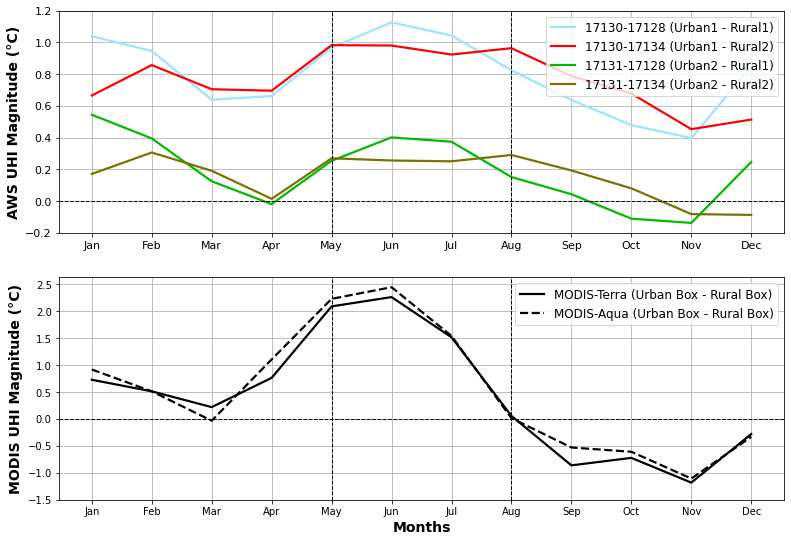

In [23]:
plt.rcParams['figure.figsize'] = 13, 9
fig = plt.figure()
ax = fig.add_subplot(2,1,1)
ax2 = fig.add_subplot(2,1,2)

dataset_UHI_monthly_yearly_mean['urban1-rural1'].plot(ax=ax, color='#9be3ff', label='17130-17128 (Urban1 - Rural1)', linewidth=2.2)
dataset_UHI_monthly_yearly_mean['urban1-rural2'].plot(ax=ax, color='#f00', label='17130-17134 (Urban1 - Rural2)', linewidth=2.2)
dataset_UHI_monthly_yearly_mean['urban2-rural1'].plot(ax=ax, color='#00b900', label='17131-17128 (Urban2 - Rural1)', linewidth=2.2)
dataset_UHI_monthly_yearly_mean['urban2-rural2'].plot(ax=ax, color='#797100', label='17131-17134 (Urban2 - Rural2)', linewidth=2.2)
MODIS_terra_monthly_yearly_mean.plot(ax=ax2, color='black', label='MODIS-Terra (Urban Box - Rural Box)', linewidth=2.2)
MODIS_aqua_monthly_yearly_mean.plot(ax=ax2, color='black', linestyle='--', label='MODIS-Aqua (Urban Box - Rural Box)', linewidth=2.2)

ax.tick_params(axis='y', labelsize=11)
ax.tick_params(axis='x', labelsize=11)
ax.axhline(y=0, linewidth=1, linestyle='--', color='black')
ax.axvline(x=4, linewidth=1, linestyle='--', color='black')
ax.axvline(x=7, linewidth=1, linestyle='--', color='black')
ax2.axhline(y=0, linewidth=1, linestyle='--', color='black')
ax2.axvline(x=5, linewidth=1, linestyle='--', color='black')
ax2.axvline(x=8, linewidth=1, linestyle='--', color='black')
ax.legend(fontsize='large')
ax2.legend(fontsize='large')
ax2.set_xlabel('Months', fontsize=14, fontweight='bold')
ax.set_ylabel('AWS UHI Magnitude (°C)', fontsize=14, fontweight='bold')
ax2.set_ylabel('MODIS UHI Magnitude (°C)', fontsize=14, fontweight='bold')

ax.set_xticks([ 0,  1., 2,  3., 4,  5., 6, 7., 8, 9, 10, 11])
ax.set_yticks([-0.2, 0, 0.2, 0.4, 0.6, 0.8, 1.0, 1.2])
ax.set_xticklabels(months)
ax.grid()

ax2.set_xticks([ 1., 2,  3., 4,  5., 6, 7., 8, 9, 10, 11, 12])
ax2.set_yticks([-1.5, -1.0, -0.5, 0, 0.5, 1.0, 1.5, 2.0, 2.5])
ax2.set_xticklabels(months)
ax2.grid()

plt.savefig(r'pictures\FigureS2.jpeg',
              bbox_inches='tight', optimize=True, progressive=True, dpi=500)